### **Scoring des documents**
---

In [104]:
# Imports
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import string
import random

import torch
from torch import optim
from torch import nn
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

#### **Pipeline traitement des documents**
---

In [3]:
def show_firsts_characters(character_list):
    num_chars = min(6, len(character_list))
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))

    for idx in range(num_chars):
        ax = axes.flat[idx]
        ax.imshow(character_list[idx], cmap='gray')
        ax.set_title(f"Caractère {idx+1}")
        ax.axis('off')

    for idx in range(num_chars, 6):
        axes.flat[idx].axis('off')

    plt.tight_layout()
    plt.show()

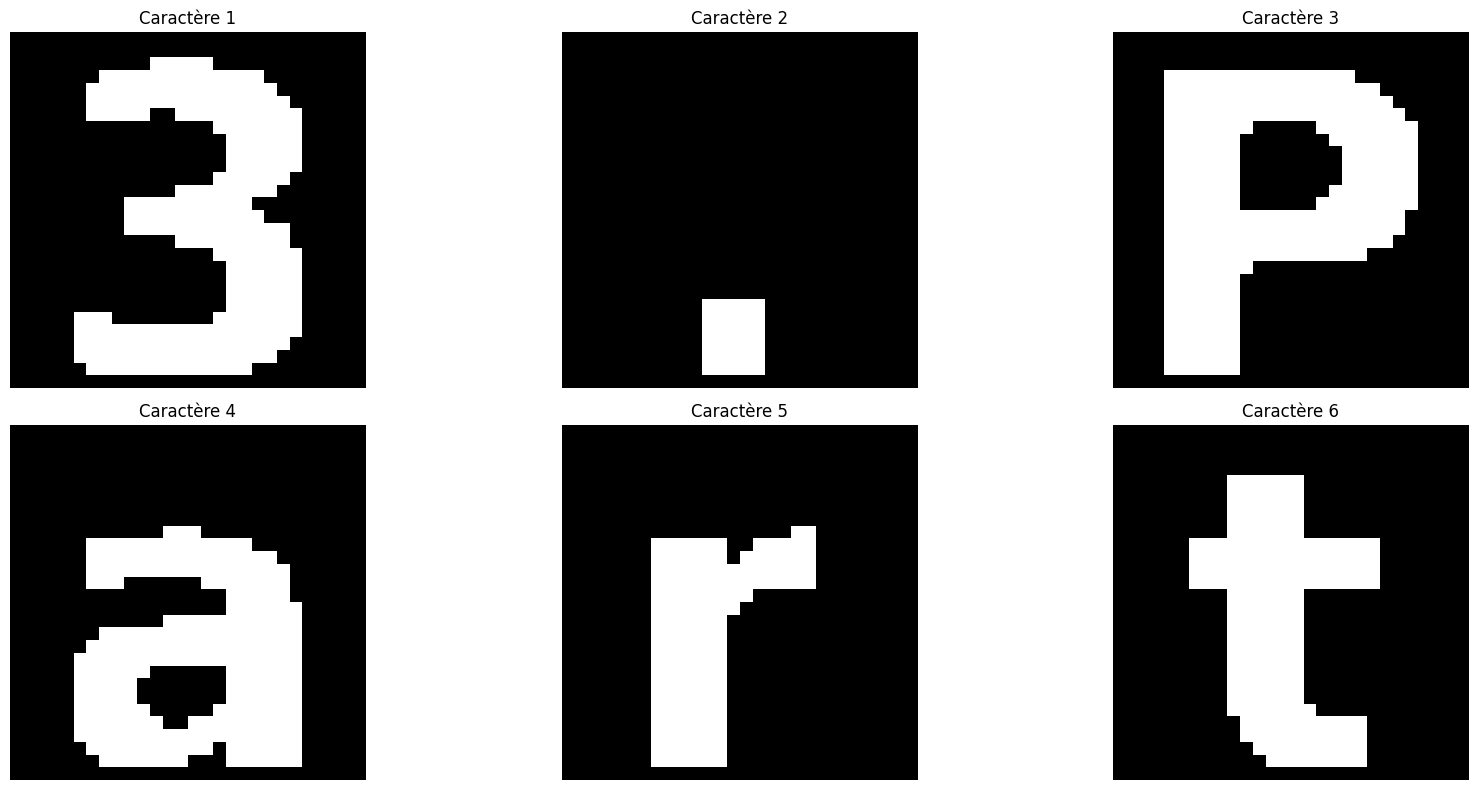

In [78]:
def load_binarize(file_path):
    file = Image.open(file_path).convert("L")
    file_array = np.array(file)

    file_binary = np.zeros_like(file_array, dtype=np.uint8)
    file_binary[file_array > 100] = 1
    file_binary[file_binary != 1] = 0

    return file_binary

def characters_extraction(doc_binary, threshold=0.999):
    line_breaks = []
    block = 1
    writings_flag = False

    for i, row in enumerate(doc_binary):
        white_ratio = row.mean()
        if white_ratio > threshold:
            line_breaks.append(0)
            if writings_flag:
                block += 1
                writings_flag = False
        else:
            writings_flag = True
            line_breaks.append(block)

    new_rows = [doc_binary[i, :] for i, seg in enumerate(line_breaks) if seg != 0]
    writings = np.array(new_rows)

    character_list = []
    unique_lines = sorted(set(line_breaks) - {0})
    for line_id in unique_lines:
        line_indices = [i for i, seg in enumerate(line_breaks) if seg == line_id]
        sub_writing = doc_binary[line_indices, :]

        in_letter = False
        start_col = 0
        for col in range(sub_writing.shape[1]):
            if sub_writing[:, col].min() == 0 and not in_letter:
                in_letter = True
                start_col = col
            elif sub_writing[:, col].min() != 0 and in_letter:
                letter_img = sub_writing[:, start_col:col]
                character_list.append((letter_img != 0).astype(np.uint8))
                in_letter = False

        if in_letter:
            letter_img = sub_writing[:, start_col:]
            character_list.append((letter_img != 0).astype(np.uint8))

    return line_breaks, writings, character_list

def padding(chars_list):
    padded_chars = []
    for char_roi in chars_list:
        h, w = char_roi.shape
        if h > 28 or w > 28:
            scale = 28 / max(h, w)
            new_h, new_w = int(h * scale), int(w * scale)
            new_h = max(1, new_h)
            new_w = max(1, new_w)
            char_roi = cv2.resize(char_roi, (new_w, new_h), interpolation=cv2.INTER_AREA)
            h, w = new_h, new_w

        padded = np.ones((28, 28), dtype=np.uint8)
        pad_x = (28 - w) // 2
        pad_y = (28 - h) // 2
        padded[pad_y:pad_y + h, pad_x:pad_x + w] = char_roi

        prep_nn_char = (padded == 0).astype(np.uint8)
        padded_chars.append(prep_nn_char)

    return padded_chars

def _pipeline(file_path):
    bin_img = load_binarize(file_path)
    _, _, chars = characters_extraction(bin_img)
    return padding(chars)

chars_padded = _pipeline("data/docs_samples/imgs/doc3.png")
show_firsts_characters(chars_padded)

#### **Model import**
---

In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels//4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels//4),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels//4, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        return self.block(x)
        
class VGGLikeNN(nn.Module):
    def __init__(self, channels_param, num_classes):
        super().__init__()
        
        self.features = nn.ModuleList()
        for in_chan, out_chan in channels_param:
            self.features.append(VGGBlock(in_chan, out_chan))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(num_classes)
        )

    def forward(self, x, log_activations=False):
        activations = {}

        for i, block in enumerate(self.features):
            x = block(x)
            if log_activations:
                activations[f'block{i+1}_out'] = x

        logits = self.classifier(x)
        if log_activations:
            activations['logits'] = logits
            return logits, activations
        
        return logits

In [ ]:
best_model = VGGLikeNN([(1, 32), (32, 256), (256, 512), (512, 1024)], 63)
best_model.load_state_dict(torch.load("research/models/fine_tuned_vgg.pth"))

<All keys matched successfully>

#### **Test on extracted characters**
---

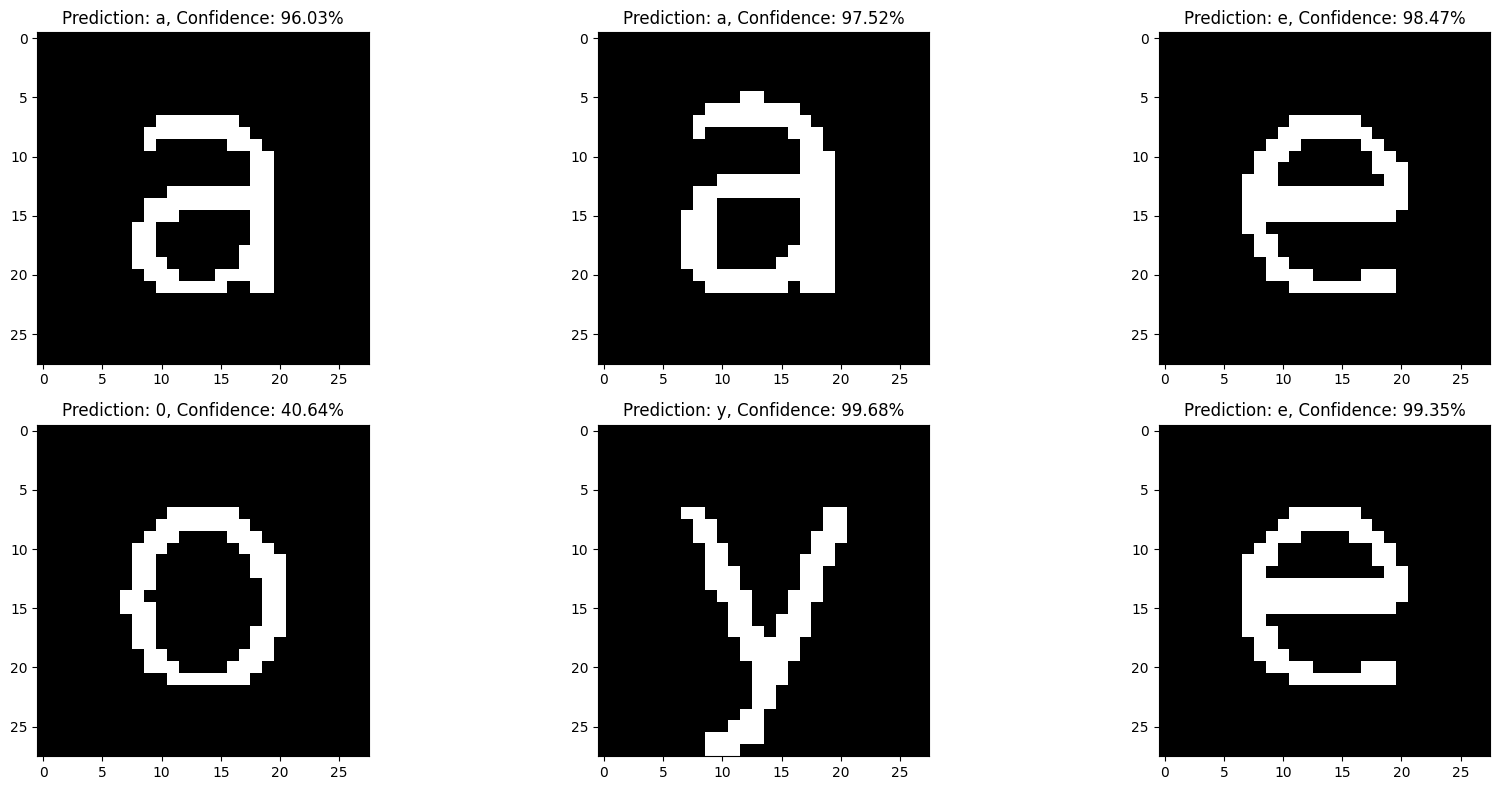

In [39]:
characters = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
class_names = {i + 1: char for i, char in enumerate(characters)}

random_indices = random.sample(range(len(chars_padded)), 6)
plt.figure(figsize=(18, 8))

for j, i in enumerate(random_indices):
    plt.subplot(2, 3, j + 1)
    plt.imshow(chars_padded[i], cmap='gray')

    best_model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(chars_padded[i], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        logits = best_model(input_tensor)

        if isinstance(logits, tuple):
            logits = logits[0]

        probs = F.softmax(logits, dim=1)
        prob, pred_idx = probs.max(dim=1)

    plt.title(f"Prediction: {class_names[pred_idx.item()]}, Confidence: {prob.item()*100:.2f}%")

plt.tight_layout()
plt.show()

#### **Noise Addition to Documents**
---

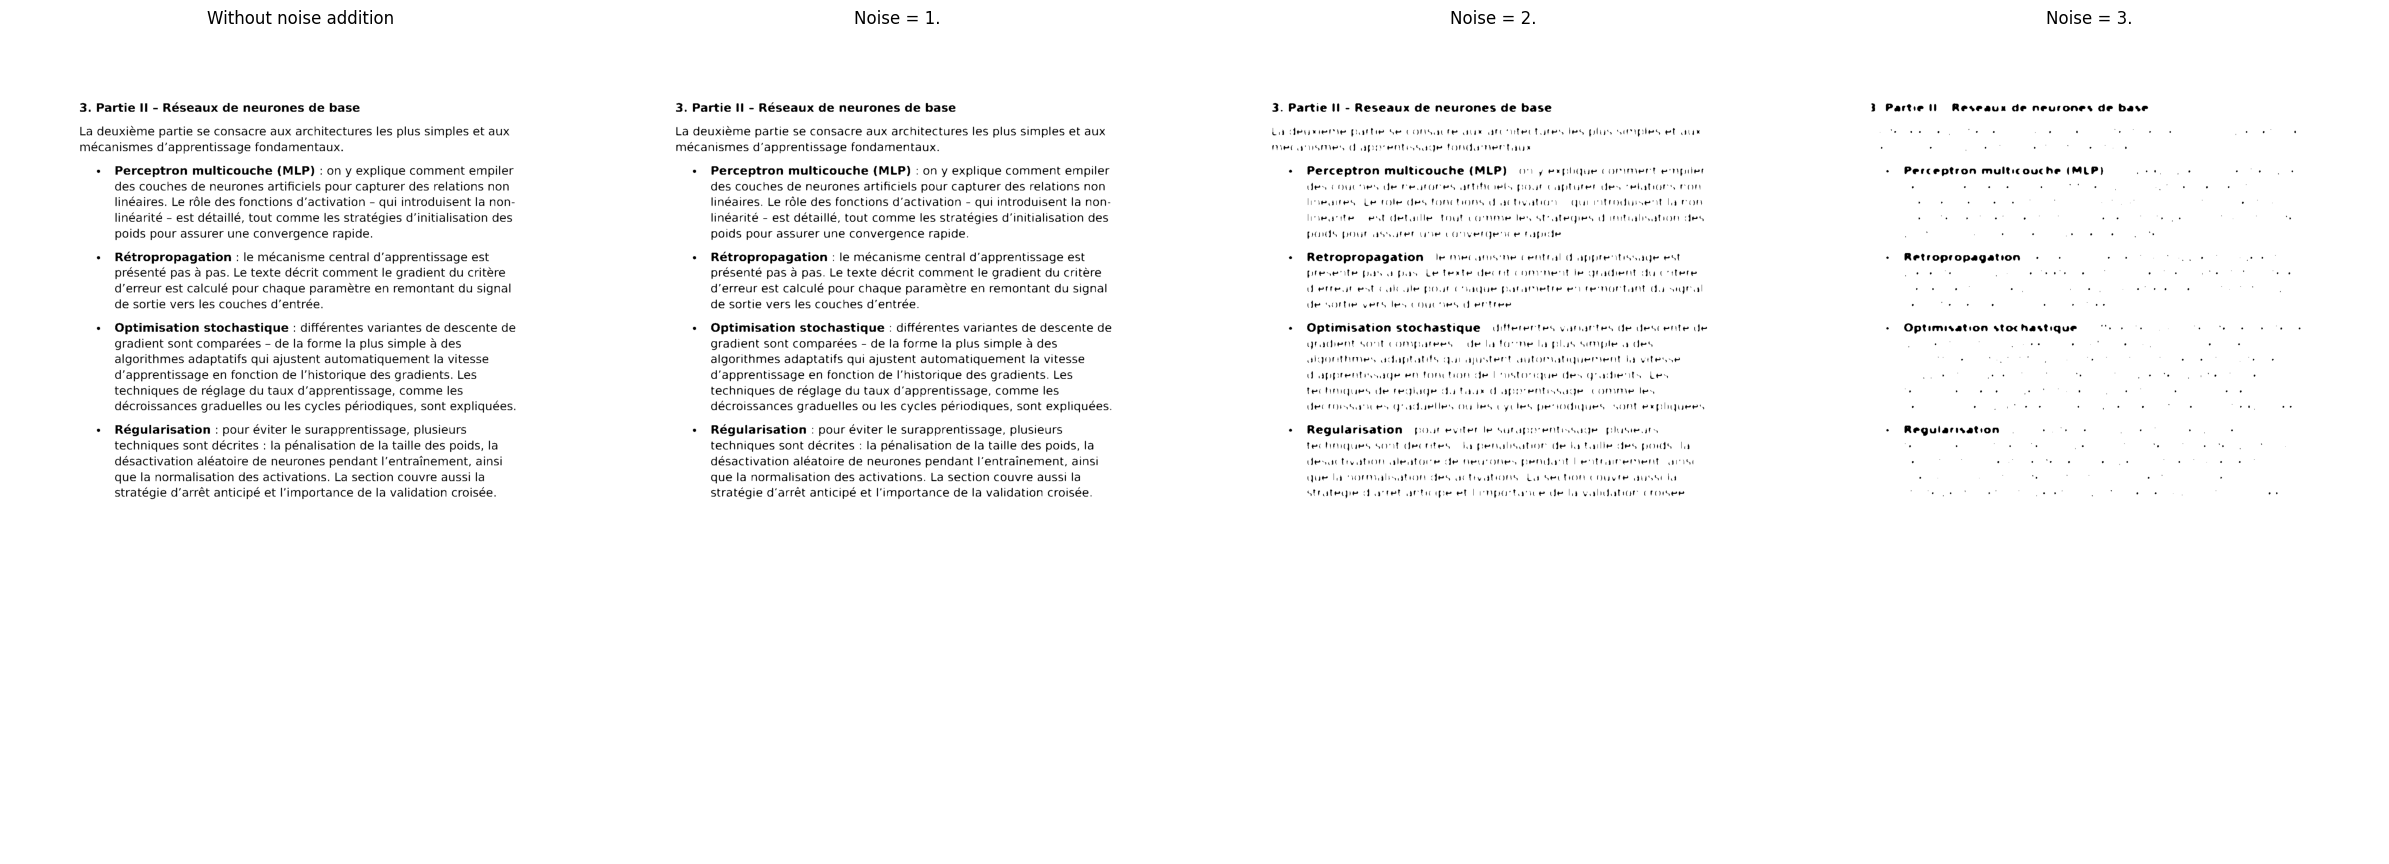

In [70]:
def degrade_image(img_gray, sigma):
    return cv2.GaussianBlur(img_gray, ksize=(0, 0), sigmaX=sigma) if sigma > 0 else img_gray.copy()
    
document = load_binarize("data/docs_samples/imgs/doc3.png")

plt.figure(figsize=(24, 12))

plt.subplot(141)
plt.imshow(degrade_image(document, 0.), cmap='grey')
plt.title("Without noise addition")
plt.axis('off')

plt.subplot(142)
plt.imshow(degrade_image(document, 1.), cmap='grey')
plt.title("Noise = 1.")
plt.axis('off')

plt.subplot(143)
plt.imshow(degrade_image(document, 2.), cmap='grey')
plt.title("Noise = 2.")
plt.axis('off')

plt.subplot(144)
plt.imshow(degrade_image(document, 3.), cmap='grey')
plt.title("Noise = 3.")
plt.axis('off')

plt.tight_layout()
plt.show()

#### **Method Evaluation**
---

In [87]:
def document_confidence(model, list_chars):
    model.eval()
    prob_sum = 0
    
    for i in range(len(list_chars)):
        with torch.no_grad():
            input_tensor = torch.tensor(list_chars[i], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
            logits = model(input_tensor)

            if isinstance(logits, tuple):
                logits = logits[0]

            probs = F.softmax(logits, dim=1)
            prob, _ = probs.max(dim=1)
            prob_sum += prob

    return prob_sum / len(list_chars)

In [88]:
def degraded_characters_extraction(file_path, noise_level):
    img = load_binarize(file_path)
    degraded_img = degrade_image(img, noise_level)
    _, _, chars = characters_extraction(degraded_img)
    
    return padding(chars)

In [107]:
def doc_eval(file_path, noise, model):
    list_chars = degraded_characters_extraction(file_path, noise)
    confidence = document_confidence(model, list_chars)

    return confidence.numpy()

In [109]:
noise_lvls = [i/4 for i in range(0, 21)]
results = {s: [] for s in noise_lvls}
folder = "data/docs_samples/imgs"

for fname in os.listdir(folder):
    file_path = os.path.join(folder, fname)

    for noise in noise_lvls:
        results[noise].append(doc_eval(file_path, noise, best_model))

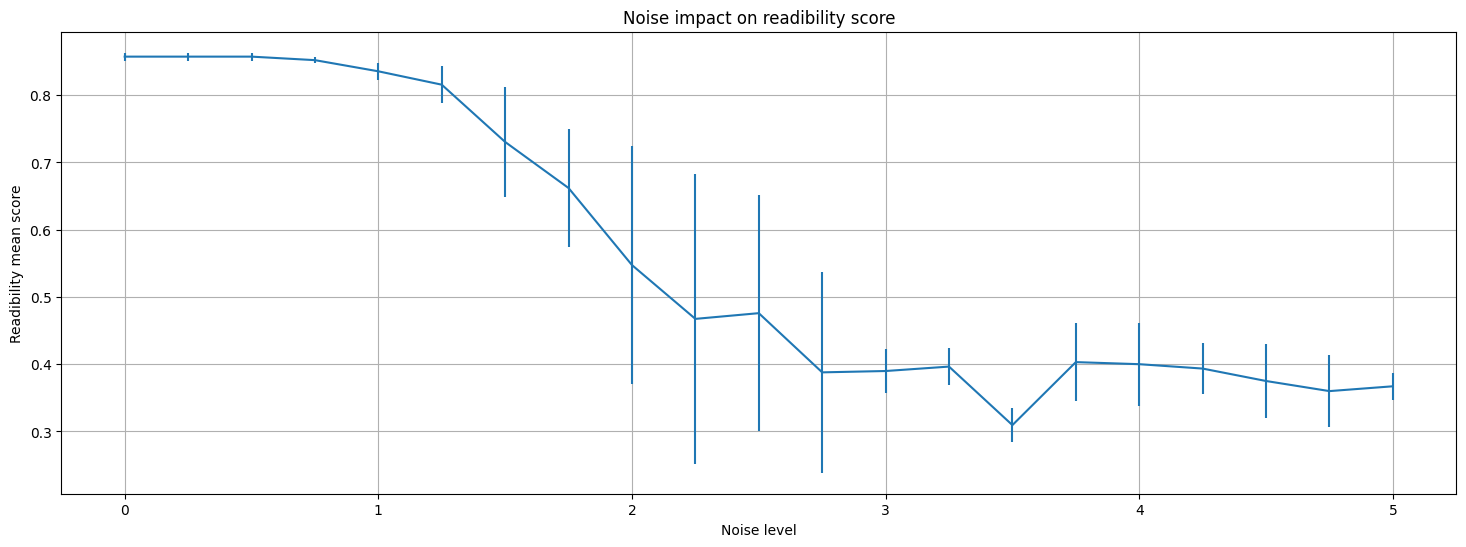

In [113]:
means = [np.mean(results[n]) for n in noise_lvls]
stds = [np.std(results[n]) for n in noise_lvls]

plt.figure(figsize=(18, 6))

plt.errorbar(noise_lvls, means, yerr=stds)
plt.xlabel('Noise level')
plt.ylabel('Readibility mean score')
plt.title('Noise impact on readibility score')

plt.grid(True)
plt.show()